## Create binary UP and DOWN class from target variable ##

In [77]:
from zigzag import peak_valley_pivots, max_drawdown, compute_segment_returns, pivots_to_modes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

In [78]:
target_quote = 'EUR/GBP' # TARGET VARIABLE
# sample interval is of 30 seconds
df = pd.read_pickle('cotes_21hs_29_may_16_6hours.pandas')  
df = df.set_index(pd.DatetimeIndex(df['time']))
del df['time']
#df.resample?

In [83]:
# resample downsampling to 5T samples or 5*30s = 2:30
# 30S segundo, 1 T minuto
# ........................ 1T
df = df.resample('30S', label='right', closed='right').pad()

In [84]:
df.head(4)

,EUR/USD,USD/JPY,GBP/USD,EUR/GBP,USD/CHF,USD/CAD
2016-05-29 21:15:30,1.11052,110.00779,1.46142,0.75996,0.99503,1.30591
2016-05-29 21:16:00,1.11055,110.00763,1.46149,0.75994,0.99493,1.30589
2016-05-29 21:16:30,1.11048,110.00769,1.46141,0.75996,0.99498,1.30595
2016-05-29 21:17:00,1.11051,110.00785,1.46132,0.76001,0.99501,1.30598


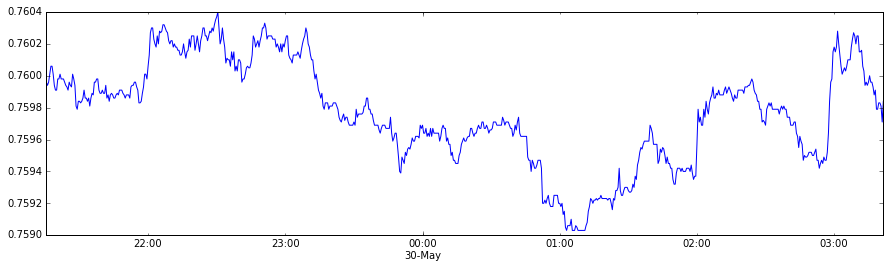

In [89]:
X = pd.DataFrame(df[target_quote]) # TARGET VARIABLE
f = plt.figure(figsize=(15,4))
X[target_quote].plot()

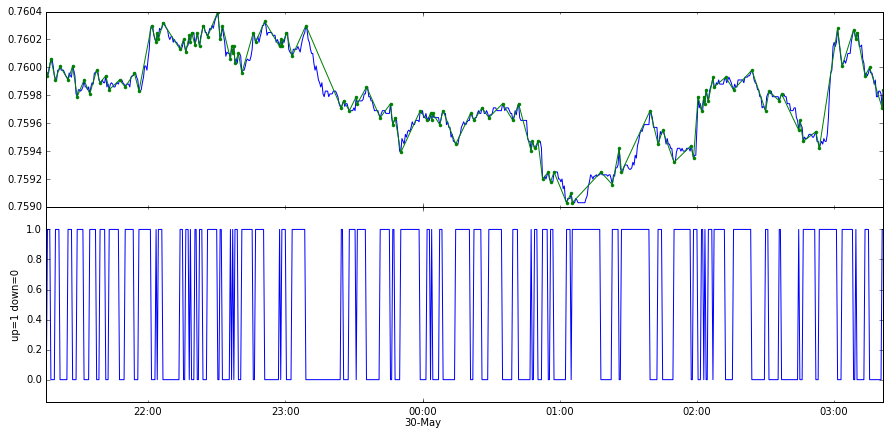

In [114]:
pivots = peak_valley_pivots(X[target_quote].values, 0.00006, -0.00006)
spivots = pd.Series(pivots, index=X.index)
spivots = spivots[pivots != 0] # just the pivots point, when it changes to up or down
X['pivots'] = pd.Series(pivots, index=X.index) # adding a collum
f, axr = plt.subplots(2, sharex=True, figsize=(15,7))
f.subplots_adjust(hspace=0)
X[target_quote].plot(ax=axr[0])
X.loc[spivots.index, target_quote].plot(ax=axr[0], style='.-')

# make class of up (1) or down (0) trends from the zigzap indicator
for i in range(len(spivots)-1):
    X.loc[ (X.index >= spivots.index[i]) & 
          (X.index < spivots.index[i+1]), 'du' ] = X['pivots'][spivots.index[i]]
X.iat[-1, 2] = X.iat[-2, 2] # replicate in the end ups or downs
X['du'] = -X['du']
X.loc[:, 'du'].where( X['du'] > 0, 0, inplace=True) # where is bigger than zero dont change
# 1 is up trend, 0 is down trend
X['du'].plot(ax=axr[1])
plt.ylim(-0.15, 1.15)
plt.ylabel('up=1 down=0')

### For training of classification model ### 

Based on this guy [here](https://www.mql5.com/en/articles/1165) 

We will move 1 sample to the left (losing the right most).

This way we will be the target variable training our model with a **forecast of one sample**

The next **sample** will go **up** or **down**?



(-0.15, 1.15)

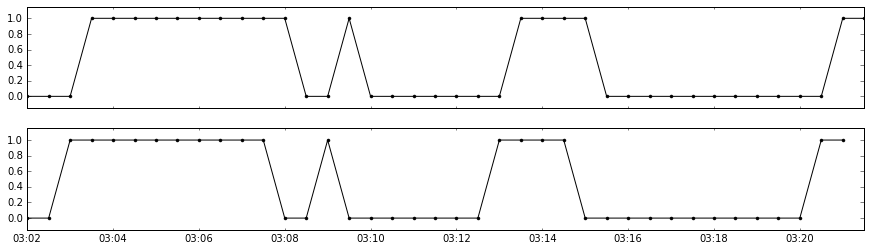

In [91]:
shift = 1 # shift -1 sample to the left
f, axr = plt.subplots(2, sharex=True, figsize=(15,4))
X['du'][-40:].plot(style='.-k', ax=axr[0])
axr[0].set_ylim(-0.15, 1.15)
X['dup'] = X['du'].shift(-shift) 
X['dup'][-40:].plot(style='.-k', ax=axr[1])
axr[1].set_ylim(-0.15, 1.15)

In [13]:
X[target_quote+' '+'dup'] = X['dup']

In [14]:
X = X['dup']

In [15]:
X.to_pickle('target_variable_dup.pandas')